**Import Statements**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from nltk.stem import PorterStemmer
from nltk import word_tokenize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
import tkinter
from tkinter import *
from sklearn.ensemble import RandomForestClassifier


Reading the Data file. The data file size is 115mb, it has **434891** entries

In [ ]:
steam_review = pd.read_csv("/content/drive/MyDrive/steam_reviews.csv")

In [ ]:
steam_review.head()

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,review,title
0,2019-02-10,2,4,578,False,Recommended,&gt Played as German Reich&gt Declare war on B...,Expansion - Hearts of Iron IV: Man the Guns
1,2019-02-10,0,0,184,False,Recommended,yes.,Expansion - Hearts of Iron IV: Man the Guns
2,2019-02-07,0,0,892,False,Recommended,Very good game although a bit overpriced in my...,Expansion - Hearts of Iron IV: Man the Guns
3,2018-06-14,126,1086,676,False,Recommended,Out of all the reviews I wrote This one is pro...,Dead by Daylight
4,2017-06-20,85,2139,612,False,Recommended,Disclaimer I survivor main. I play games for f...,Dead by Daylight


In [ ]:
steam_review.describe()

,funny,helpful,hour_played
count,4.348910e+05,434891.000000,434891.000000
mean,5.333024e+05,1.004114,364.130773
std,4.785640e+07,59.462935,545.961198
min,0.000000e+00,0.000000,0.000000
25%,0.000000e+00,0.000000,62.000000
50%,0.000000e+00,0.000000,190.000000
75%,0.000000e+00,0.000000,450.000000
max,4.294967e+09,28171.000000,31962.000000


**Data Preprocessing**

Checking if there are any null values present in the Dataset. We will be cleaning them out as they can affect our predections.

In [ ]:
steam_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434891 entries, 0 to 434890
Data columns (total 8 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   date_posted             434891 non-null  object
 1   funny                   434891 non-null  int64 
 2   helpful                 434891 non-null  int64 
 3   hour_played             434891 non-null  int64 
 4   is_early_access_review  434891 non-null  bool  
 5   recommendation          434891 non-null  object
 6   review                  433375 non-null  object
 7   title                   434891 non-null  object
dtypes: bool(1), int64(3), object(4)
memory usage: 23.6+ MB


In [ ]:
steam_review.isnull().sum()

date_posted                  0
funny                        0
helpful                      0
hour_played                  0
is_early_access_review       0
recommendation               0
review                    1516
title                        0
dtype: int64

In [ ]:
steam_review = steam_review.dropna()

In [ ]:
steam_review.isnull().sum()

date_posted               0
funny                     0
helpful                   0
hour_played               0
is_early_access_review    0
recommendation            0
review                    0
title                     0
dtype: int64

In [ ]:
steam_review.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 433375 entries, 0 to 434890
Data columns (total 8 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   date_posted             433375 non-null  object
 1   funny                   433375 non-null  int64 
 2   helpful                 433375 non-null  int64 
 3   hour_played             433375 non-null  int64 
 4   is_early_access_review  433375 non-null  bool  
 5   recommendation          433375 non-null  object
 6   review                  433375 non-null  object
 7   title                   433375 non-null  object
dtypes: bool(1), int64(3), object(4)
memory usage: 26.9+ MB


In [ ]:
steam_review.recommendation.value_counts()


Recommended        302751
Not Recommended    130624
Name: recommendation, dtype: int64

**Data Visualization**

Games Recommended Vs Not Recommended besed on the review

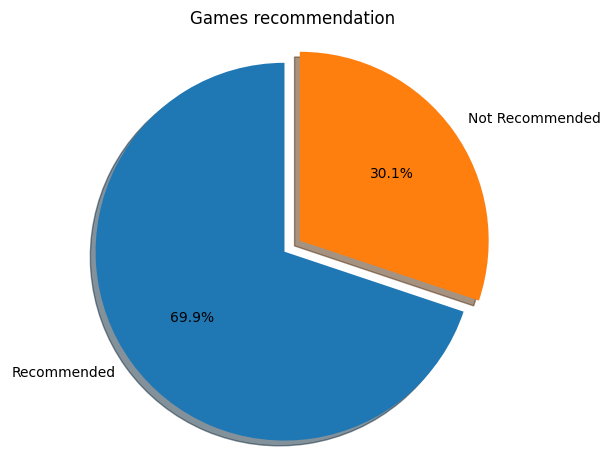

In [ ]:
graph_sizes = [steam_review.recommendation.value_counts()[0], steam_review.recommendation.value_counts()[1]]
labels = ["Recommended", "Not Recommended"]

explode = (0, 0.1)
fig1, ax1 = plt.subplots()
ax1.set_title('Games recommendation')
ax1.pie(graph_sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)

ax1.axis('equal')
plt.tight_layout()
plt.show()


Hours Played Vs Number of Reviews

Text(0, 0.5, 'Number of reviews')

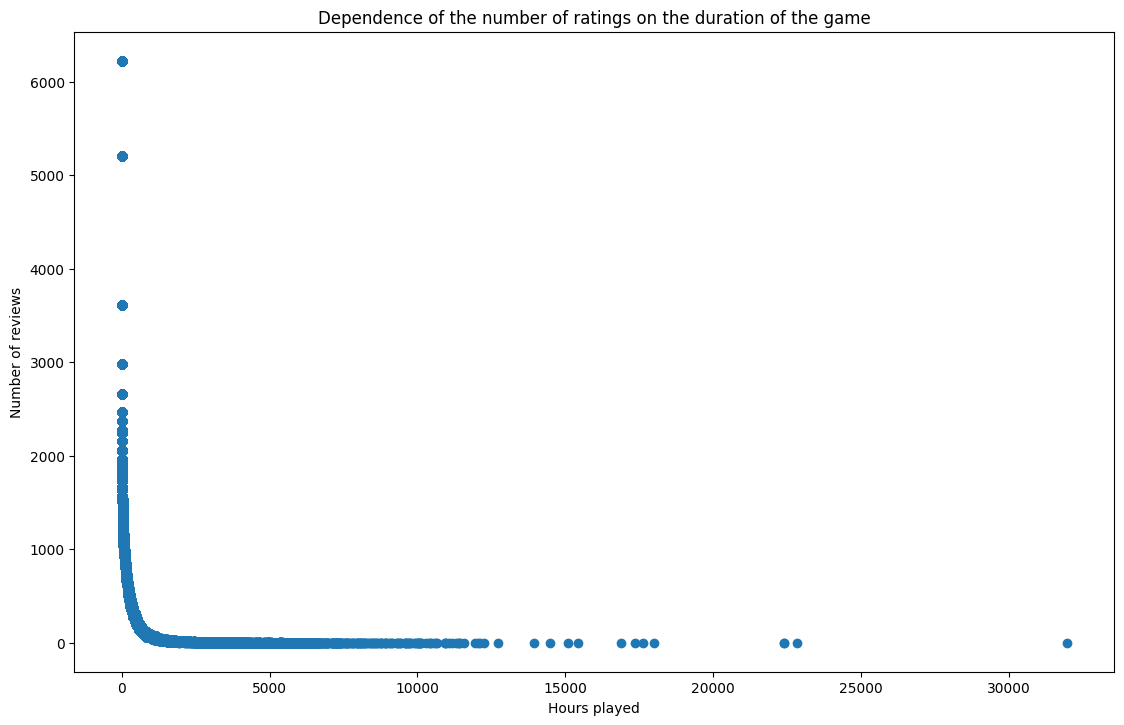

In [ ]:
steam_review['hour_played_reviews'] = steam_review.groupby('hour_played')['hour_played'].transform('count')
x = steam_review.hour_played
y = steam_review['hour_played_reviews']
fig = plt.figure(figsize = (13,8))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.scatter(x,y)
ax.set_title('Dependence of the number of ratings on the duration of the game')
ax.set_xlabel('Hours played')
ax.set_ylabel('Number of reviews')


**Top 10 Most Reviewed Games**

In [ ]:
top_games = steam_review.title.value_counts()
print("Top 10 games are\n\n",steam_review.title.value_counts()[:10])

Top 10 games are

 PLAYERUNKNOWN'S BATTLEGROUNDS                  144846
Grand Theft Auto V                              99677
Rust                                            70907
Rocket League®                                  67765
Dead by Daylight                                22178
MONSTER HUNTER: WORLD                           18390
ASTRONEER                                        2658
The Elder Scrolls V: Skyrim Special Edition      1471
RESIDENT EVIL 2 / BIOHAZARD RE:2                 1384
Sid Meier’s Civilization® VI                      522
Name: title, dtype: int64


Creating new Coloumn To Label encode Recommendation

In [ ]:
steam_review['review_length'] = steam_review.apply(lambda row: len(str(row['review'])), axis=1)

steam_review['recommendation_int'] = steam_review['recommendation'] == 'Recommended'
steam_review['recommendation_int'] = steam_review['recommendation_int'].astype(int)

Plot of each game Vs the number of positive and negative reviews

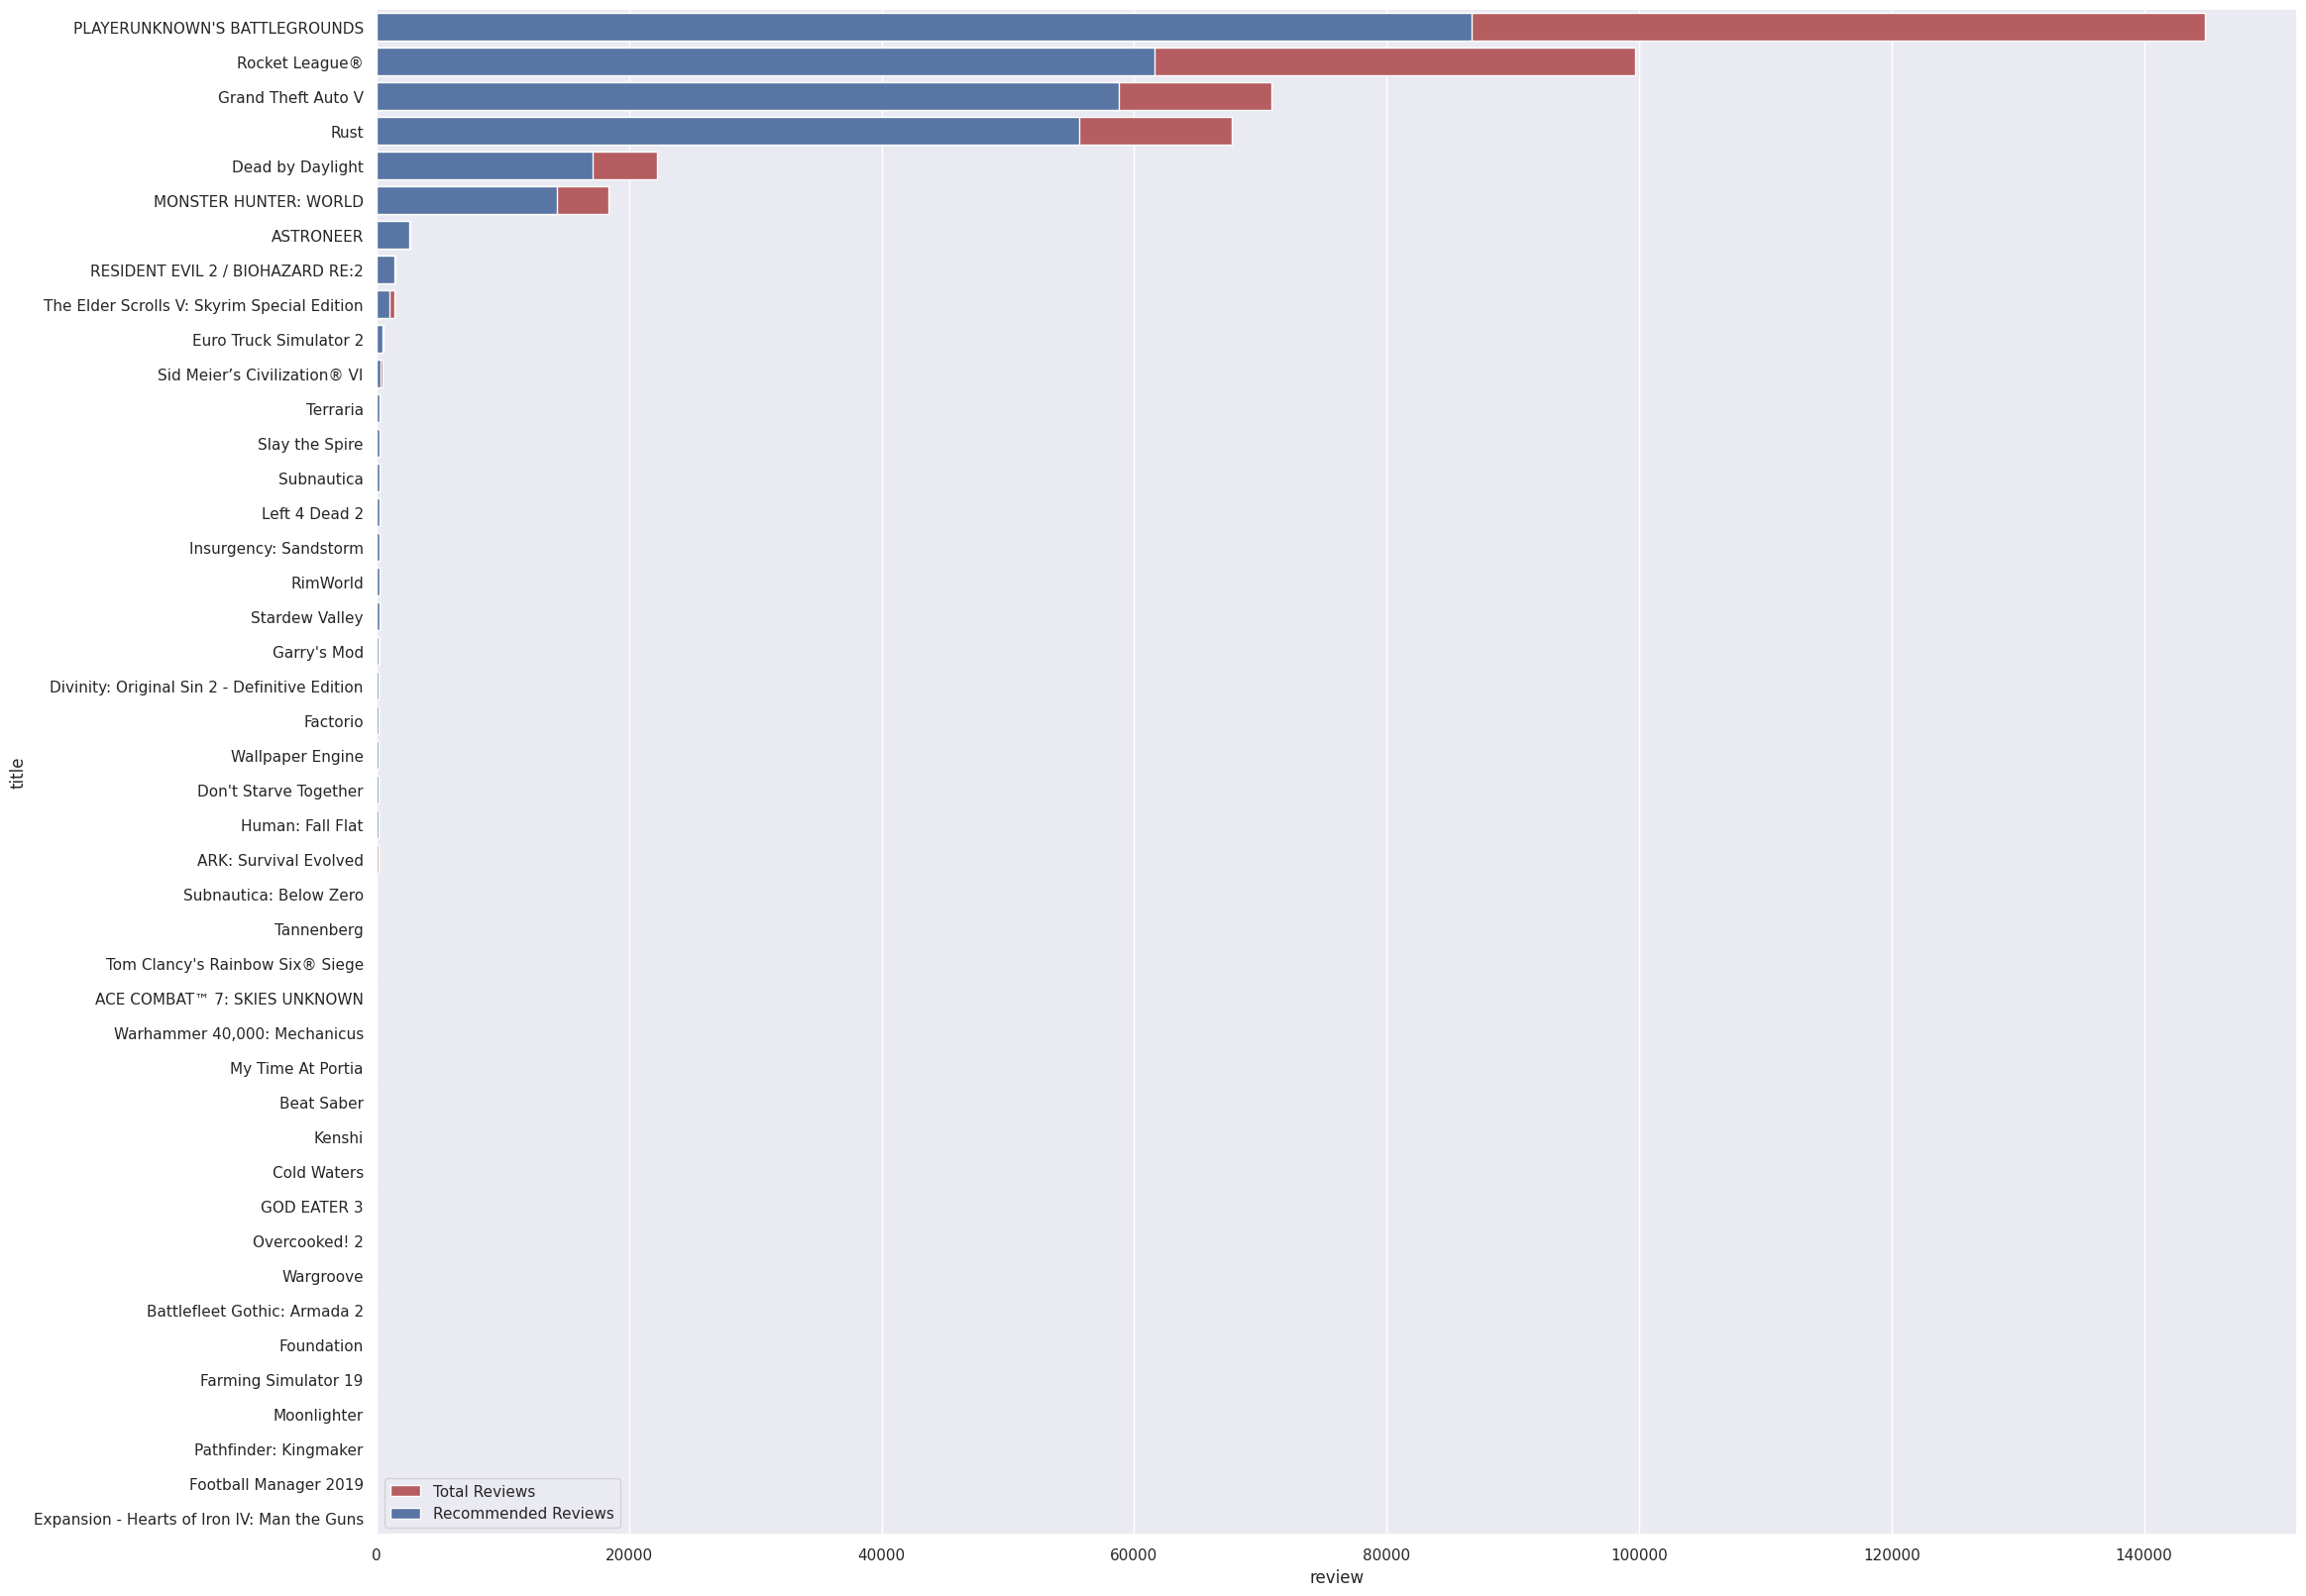

In [ ]:
reviews_count = steam_review.groupby(['title'])['review'].count().sort_values(ascending=False)

reviews_count = reviews_count.reset_index()

sns.set(style="darkgrid")
plt.figure(figsize=(25,20))
sns.barplot(y=reviews_count['title'], x=reviews_count['review'], data=reviews_count,
            label="Total Reviews", color="r")

reviews_count_pos = steam_review.groupby(['title', 'recommendation_int'])['review'].count().sort_values(ascending=False)
reviews_count_pos = reviews_count_pos.reset_index()
reviews_count_pos = reviews_count_pos[reviews_count_pos['recommendation_int'] == 1]
sns.barplot(y=reviews_count_pos['title'], x=reviews_count_pos['review'], data=reviews_count_pos,
            label="Recommended Reviews", color="b")
plt.legend()


Assigning integer value for recommended and not recommended as it will be easier for working.

In [ ]:
steam_review

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,review,title,review_length,recommendation_int
0,2019-02-10,2,4,578,False,Recommended,&gt Played as German Reich&gt Declare war on B...,Expansion - Hearts of Iron IV: Man the Guns,195,1
1,2019-02-10,0,0,184,False,Recommended,yes.,Expansion - Hearts of Iron IV: Man the Guns,4,1
2,2019-02-07,0,0,892,False,Recommended,Very good game although a bit overpriced in my...,Expansion - Hearts of Iron IV: Man the Guns,171,1
3,2018-06-14,126,1086,676,False,Recommended,Out of all the reviews I wrote This one is pro...,Dead by Daylight,2094,1
4,2017-06-20,85,2139,612,False,Recommended,Disclaimer I survivor main. I play games for f...,Dead by Daylight,1397,1
...,...,...,...,...,...,...,...,...,...,...
434886,2018-11-17,1,37,10,False,Recommended,YOUR FLESH WILL ROT AND DECAY.STEEL IS IMMORTA...,"Warhammer 40,000: Mechanicus",1977,1
434887,2018-11-17,3,41,38,False,Recommended,Domini and Dominae I believe what we are deali...,"Warhammer 40,000: Mechanicus",2535,1
434888,2018-11-20,0,0,36,False,Recommended,First off if you like X Com style of games you...,"Warhammer 40,000: Mechanicus",730,1
434889,2018-11-18,1,44,12,False,Recommended,As a disclaimer I'm an AdMech player on the ta...,"Warhammer 40,000: Mechanicus",1789,1


In [ ]:
steam_review.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 433375 entries, 0 to 434890
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   date_posted             433375 non-null  object
 1   funny                   433375 non-null  int64 
 2   helpful                 433375 non-null  int64 
 3   hour_played             433375 non-null  int64 
 4   is_early_access_review  433375 non-null  bool  
 5   recommendation          433375 non-null  object
 6   review                  433375 non-null  object
 7   title                   433375 non-null  object
 8   review_length           433375 non-null  int64 
 9   recommendation_int      433375 non-null  int64 
dtypes: bool(1), int64(5), object(4)
memory usage: 33.5+ MB


**Data Cleaning**

Converting all the reviews to lower case and removing special characters

In [ ]:
steam_review['review'] = [review.strip().lower() for review in steam_review['review']]
steam_review['review'] = steam_review['review'].replace(r"[^a-zA-Z\d\_\+\-\'\.\/\s]+", ' ', regex = True)
steam_review['review'] = steam_review['review'].replace(["./ ", "' ", " '"], " ", regex = True)

In [ ]:
stemmer=PorterStemmer()
for i in range(len(steam_review['review'])):
  words = word_tokenize(steam_review.iloc[i,6])
  sentence = [stemmer.stem(j) for j in words]
  steam_review.iloc[i,6] = ' '.join(sentence)

In [ ]:
steam_review.head()


,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,review,title,review_length,recommendation_int
0,2019-02-10,2,4,578,False,Recommended,gt play a german reich gt declar war on belgiu...,Expansion - Hearts of Iron IV: Man the Guns,195,1
1,2019-02-10,0,0,184,False,Recommended,ye .,Expansion - Hearts of Iron IV: Man the Guns,4,1
2,2019-02-07,0,0,892,False,Recommended,veri good game although a bit overpr in my opi...,Expansion - Hearts of Iron IV: Man the Guns,171,1
3,2018-06-14,126,1086,676,False,Recommended,out of all the review i wrote thi one is proba...,Dead by Daylight,2094,1
4,2017-06-20,85,2139,612,False,Recommended,disclaim i survivor main . i play game for fun...,Dead by Daylight,1397,1


**Building Classification Model**

We will be diving the data into Train data, Test data and Dev data using train_test_split.

In [ ]:
data_frame = steam_review

In [ ]:
data_frame, test_data = train_test_split(data_frame, test_size=0.20)

In [ ]:
train_data, dev_data = train_test_split(data_frame, test_size=0.20)

Text(0.5, 0, 'Rating')

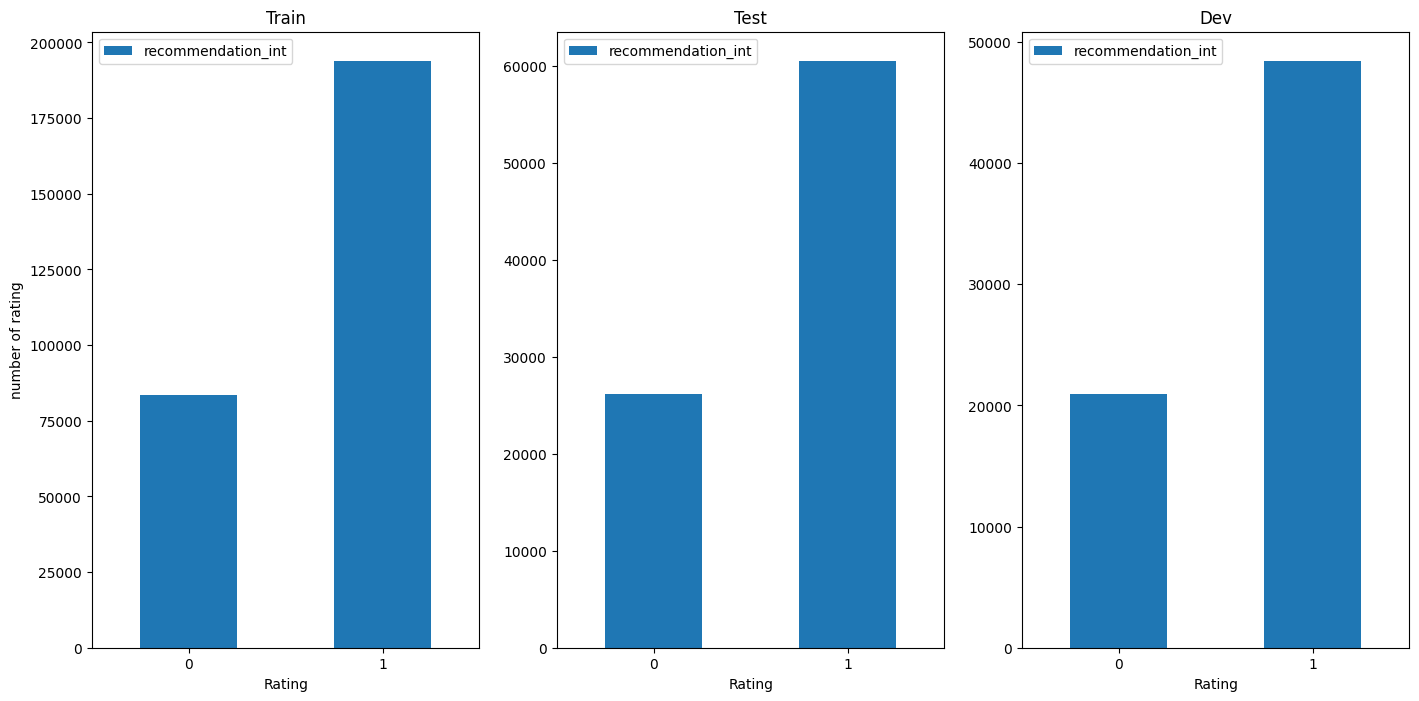

In [ ]:
fig, axes = plt.subplots(ncols=3)

plot1 = train_data.recommendation_int.value_counts().sort_index().plot(kind='bar', legend=True, rot=0, ax=axes[0])
plot1.set_title("Train")
plot1.set_xlabel("Rating")
plot1.set_ylabel("number of rating")
plot2 = test_data.recommendation_int.value_counts().sort_index().plot(kind='bar', legend=True, rot=0, ax=axes[1])
plot2.set_title("Test")
plot2.set_xlabel("Rating")
plot3 = dev_data.recommendation_int.value_counts().sort_index().plot(kind='bar', legend=True, rot=0,figsize=(17, 8))
plot3.set_title("Dev")
plot3.set_xlabel("Rating")

For text analysis the best classifiers are Naive Bayes, Support Vector Machine and Random Forest Classifier

But before we train our model we have to convert reviews to TF IDF form

The formula that is used to compute the tf-idf is

tf-idf(t, d) = tf(t, d) * idf(t) and idf is computed as idf(d, t) = log [ (1 + n) / (1 + df(d, t)) ] + 1

In [ ]:
tfidf = TfidfVectorizer(max_features=1000)

# transforming traing data to tfidf form arrays. we can use this to train any model
x_train = tfidf.fit_transform(train_data['review']).toarray()
y_train = np.asarray(train_data['recommendation_int'])

In [ ]:
x_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
x_dev = tfidf.transform(dev_data['review']).toarray()
y_dev = np.asarray(dev_data['recommendation_int'])

Trying out Naive bayes Model as this is a text analysis we will use multinomial Naive Bayes.

In [ ]:
alpha = [0.01, .1, 0.5, 1, 2, 3]
multinomial_nb = {}
mse_multinomial_nb = {}
accuracy_multinomial_nb = {}
y_dev_pred_multinomial_nb = {}
for a in alpha:
    multinomial_nb[a] = MultinomialNB(alpha=a)
    multinomial_nb[a].fit(x_train, y_train)

    y_dev_pred_multinomial_nb[a] = (multinomial_nb[a].predict(x_dev))

    # Calculate the Mean Squared Error and Accuracy
    mse_multinomial_nb[a] = mean_squared_error(y_dev, y_dev_pred_multinomial_nb[a])
    accuracy_multinomial_nb[a] = accuracy_score(y_dev, y_dev_pred_multinomial_nb[a])*100

    # Print the Mean Squared Error and Accuracy
    print(f'Mean Squared Error = {mse_multinomial_nb[a]} for alpha = {a}')
    print(f'Accuracy = {accuracy_multinomial_nb[a]} for alpha = {a}')

Mean Squared Error = 0.16850302855494664 for alpha = 0.01
Accuracy = 83.14969714450534 for alpha = 0.01
Mean Squared Error = 0.16850302855494664 for alpha = 0.1
Accuracy = 83.14969714450534 for alpha = 0.1
Mean Squared Error = 0.16851745024516873 for alpha = 0.5
Accuracy = 83.14825497548313 for alpha = 0.5
Mean Squared Error = 0.16864724545716758 for alpha = 1
Accuracy = 83.13527545428325 for alpha = 1
Mean Squared Error = 0.16877704066916643 for alpha = 2
Accuracy = 83.12229593308335 for alpha = 2
Mean Squared Error = 0.16890683588116528 for alpha = 3
Accuracy = 83.10931641188347 for alpha = 3


Alpha at 0.01 gave us the best accuracy of **83.149%**

Support Vector Machines (SVM)

In [ ]:
C = [0.01, 0.1, 1, 10, 100, 1000]
svm = {}
mse_svm = {}
accuracy_svm = {}
y_dev_pred_svm = {}
for c in C:
    svm[c] = LinearSVC(C=c, dual = False)
    svm[c].fit(x_train, y_train)

    y_dev_pred_svm[c] = (svm[c].predict(x_dev))

    mse_svm[c] = mean_squared_error(y_dev, y_dev_pred_svm[c])
    accuracy_svm[c] = accuracy_score(y_dev, y_dev_pred_svm[c])*100

    print(f'Mean Squared Error = {mse_svm[c]} for C = {c}')
    print(f'Accuracy = {accuracy_svm[c]} for C = {c}')


Mean Squared Error = 0.14558696279203923 for C = 0.01
Accuracy = 85.44130372079609 for C = 0.01
Mean Squared Error = 0.14408710700894145 for C = 0.1
Accuracy = 85.59128929910585 for C = 0.1
Mean Squared Error = 0.14433227574271704 for C = 1
Accuracy = 85.5667724257283 for C = 1
Mean Squared Error = 0.1444332275742717 for C = 10
Accuracy = 85.55667724257283 for C = 10
Mean Squared Error = 0.1444332275742717 for C = 100
Accuracy = 85.55667724257283 for C = 100
Mean Squared Error = 0.1444476492644938 for C = 1000
Accuracy = 85.55523507355062 for C = 1000


We got an accuracy of **85.591%** for C = 0.1

Trying Random Forest Classifier

In [ ]:
estimators = [10, 50]
rfc = {}
mse_rfc = {}
accuracy_rfc = {}
y_dev_pred_rfc = {}
for n in estimators:
    rfc[n] = RandomForestClassifier(max_depth=25, n_estimators=n)
    rfc[n].fit(x_train, y_train)

    y_dev_pred_rfc[n] = (rfc[n].predict(x_dev))

    mse_rfc[n] = mean_squared_error(y_dev, y_dev_pred_rfc[n])
    accuracy_rfc[n] = accuracy_score(y_dev, y_dev_pred_rfc[n])*100

    print(f'Mean Squared Error = {mse_rfc[n]} for n = {n}')
    print(f'Accuracy = {accuracy_rfc[n]} for n = {n}')


Mean Squared Error = 0.19874531295067782 for n = 10
Accuracy = 80.12546870493222 for n = 10
Mean Squared Error = 0.19166426305162965 for n = 50
Accuracy = 80.83357369483704 for n = 50


This gave me an accuracy of **80.833%** for n = 50


Trying ensemble of all three model :

In [ ]:
model_1 =LinearSVC(C=0.1,dual=False)
model_2 = MultinomialNB(alpha=0.01)
model_3 = RandomForestClassifier(max_depth=25,n_estimators=10)

In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
final_model = VotingClassifier(
    estimators=[('svm', model_1), ('mnb', model_2), ('rf', model_3)], voting='hard')

In [ ]:
final_model.fit(x_train, y_train)
pred_final = final_model.predict(x_dev)

mse_en= mean_squared_error(y_dev, pred_final)
accuracy_en = accuracy_score(y_dev, pred_final)*100
print(f'Mean Squared Error = {mse_en}')
print(f'Accuracy = {accuracy_en}')

Mean Squared Error = 0.15931641188347273
Accuracy = 84.06835881165271


The model did an accuracy of **84.068%** , This was worse than our SVM model

In [ ]:
x_test = tfidf.transform(test_data['review']).toarray()
y_test = np.asarray(test_data['recommendation_int'])


Using the test data to test our best model

In [ ]:
c=0.1
y_test_pred = (svm[c].predict(x_test))

mse_test = mean_squared_error(y_test, y_test_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)*100

print(f'Mean Squared Error test = {mse_test}')
print(f'Accuracy test = {accuracy_test}')


Mean Squared Error test = 0.14155177386789733
Accuracy test = 85.84482261321027


**GUI**

In [ ]:
def to_tfid(x):
    value =  tfidf.transform(x).toarray()
    return value

def rating():
    x = textfield_label.get()
    results.delete("all")
    value = svm[c].predict(to_tfid([x]))
    if value == 0:
        text = "Negative"
    else:
        text = "Positive"
    results.create_text(200, 80, text="The comment is "+text, font='Arial 20', fill='black')
    return value

window = Tk()
window.geometry("500x500")
window.title("Game Recommender")
window.config(bg="white")
head = Label(window, text="Game Review Classifier", bg="white", foreground="black", font=("Arial", 25)).pack()
Label(window, text="Comment", bg="white", foreground="black", font=("Arial", 10)).place(x=100, y=80)
Label(window, text="______________________________", bg="white", foreground="black").place(x=173, y=90)
textfield_label = Entry(window, bg="white", foreground="black", border=0, insertbackground="white")
textfield_label.focus()
textfield_label.place(x=175, y=80, height=20, width=150)
output = Label(window, bg="white", foreground="black", font=("Arial", 25)).place(x=50, y=250)
search = Button(window, text="Predict", command=rating).place(x=175, y=175, width=150)
results = tkinter.Canvas(bg='white', width='400', height='200', highlightthickness=0)
results.place(x=50, y=250)
window.mainloop()